In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import zipfile
import io
import urllib2  #the lib that handles the url stuff


#import matplotlib
#import matplotlib.pyplot as plt
%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")

Populating the interactive namespace from numpy and matplotlib


In [2]:

os.getenv('PUIDATA')

'/home/cusp/ic1018/PUIdata'

In [3]:
os.getenv('PUI2016')

'/home/cusp/ic1018/PUI2016'

In [4]:
#filename = '{}-citibike-tripdata.zip'.format(201501)

#accesszipfile

In [5]:
### A function to download the data: simple bash commands can be run by preceding them with !
### but more complex command lines with variable arguments need to be build as strng and run with os.system
### this code cell does a lot of things: looks for existing files, download a file if none is there, unzips it, moves it.

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [6]:
datestring = '201501'
getCitiBikeCSV(datestring)

file in place, you can continue


In [7]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
# df is the dataframe where the content of the csv file is stored


In [8]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


# IDEA:
## Customers are less likely to choose biking than subscribers for commuting.


# NULL HYPOTHESIS:
## The ratio of subscribers biking on weekends over subscribers biking on weekdays is _the same_ or _higher_  than the ratio of customers biking over weekends to customers biking on weekdays


# _$H_0$_ : $\frac{Customer_{\mathrm{weekend}}}{Cus_{\mathrm{week}}} <= \frac{Subscriber_{\mathrm{weekend}}}{Subs_{\mathrm{week}}}$
# _$H_1$_ : $\frac{Customer_{\mathrm{weekend}}}{Customer_{\mathrm{week}}} > \frac{Subscriber_{\mathrm{weekend}}}{Subscriber_{\mathrm{week}}}$

or identically:

# _$H_0$_ : $\frac{Customer_{\mathrm{weekend}}}{Customer_{\mathrm{week}}} - \frac{Subscriber_{\mathrm{weekend}}}{Subs_{\mathrm{week}}} <= 0 $
# _$H_1$_ : $\frac{Customer_{\mathrm{weekend}}}{Customer_{\mathrm{week}}} - \frac{Subscriber_{\mathrm{weekend}}}{Subscriber_{\mathrm{week}}} > 0$
## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

In [9]:
# Drop any missing values and storing the data into new dataframe 'data'
data = df.dropna(subset=['usertype', 'starttime']).copy()

# Use starttime as the date
data['date'] = pd.to_datetime(data['starttime'])

# Take away all the other columns except 'date' and 'usertype'
data.drop([
        col for col in data.columns 
        if col not in ['date', 'usertype']
], axis=1, inplace=True)

data.head()

,usertype,date
0,Subscriber,2015-01-01 00:01:00
1,Subscriber,2015-01-01 00:02:00
2,Subscriber,2015-01-01 00:04:00
3,Subscriber,2015-01-01 00:04:00
4,Subscriber,2015-01-01 00:05:00


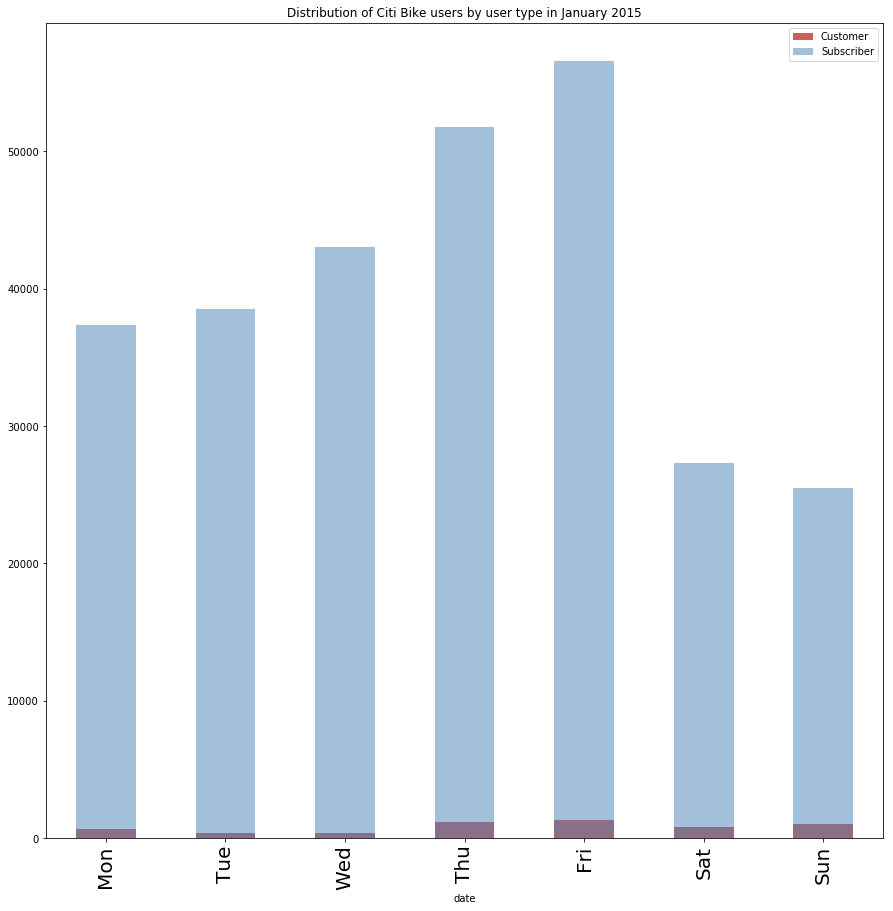

In [10]:
fig = pl.figure(figsize(15,15))

#instad of plotting with matplotlib i.e. plot() i use the plot method in pandas
norm_w = 1
((data['date'][data['usertype'] == 'Customer'].groupby([data['date'].dt.weekday]).count()) / norm_w).plot(kind="bar", 
                                                                                         color='IndianRed', 
                                                                                         label='Customer')

norm_m = 1
ax = ((data['date'][data['usertype'] == 'Subscriber'].groupby([data['date'].dt.weekday]).count()) / norm_m).plot(kind="bar", 
                                                                                              color='SteelBlue', 
                                                                                              alpha=0.5,
                                                                                              label='Subscriber')

tmp = ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
pl.title('Distribution of Citi Bike users by user type in January 2015')

pl.legend()

## Figure 1a: Distribution of Citibike bikers by usertype in January 2015, absolute counts

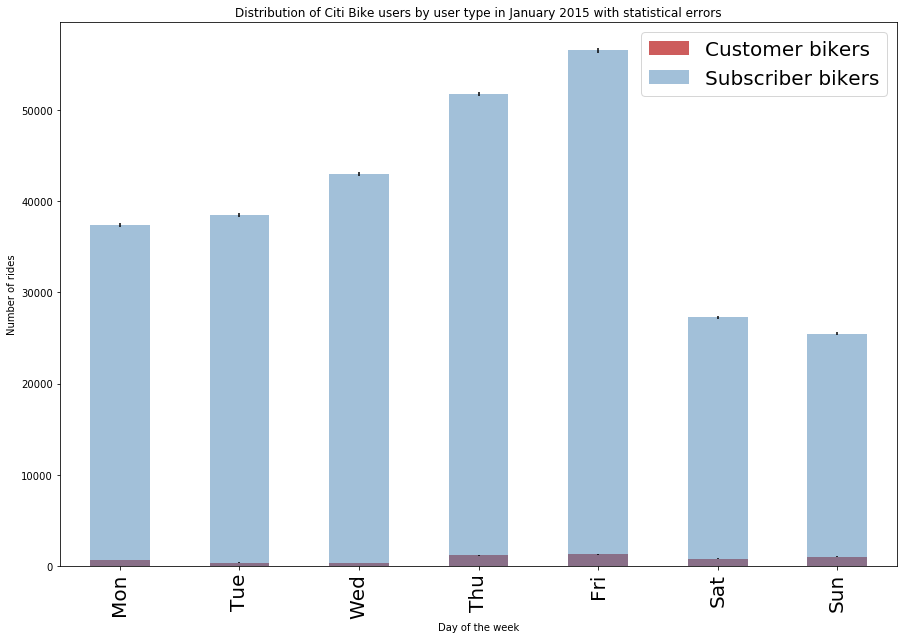

In [11]:
fig=pl.figure(figsize(15,10))

counts_c = data.date[data.usertype == 'Customer'].groupby([data.date.dt.weekday]).count()
norm_c = 1
error_c = np.sqrt(counts_c)
ax=((counts_c) / norm_c).plot(kind="bar",color='IndianRed',  yerr=[
            ((error_c) / norm_c, (error_c) / norm_c)], label='Customer bikers')


counts_s = data.date[data.usertype=="Subscriber"].groupby([data.date.dt.weekday]).count()
norm_s = 1
error_s=np.sqrt(counts_s)
((counts_s) / norm_s).plot(kind="bar", alpha=0.5, yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                           color='SteelBlue', label='Subscriber bikers')
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], fontsize=20)
ax.set_ylabel ("Number of rides")
ax.set_xlabel ("Day of the week")
pl.title('Distribution of Citi Bike users by user type in January 2015 with statistical errors')

pl.legend(['Customer bikers','Subscriber bikers'],fontsize=20)

## Figure 1b: Distribution of Citibike bikers by usertype in January 2015, absolute counts, with statistical errors

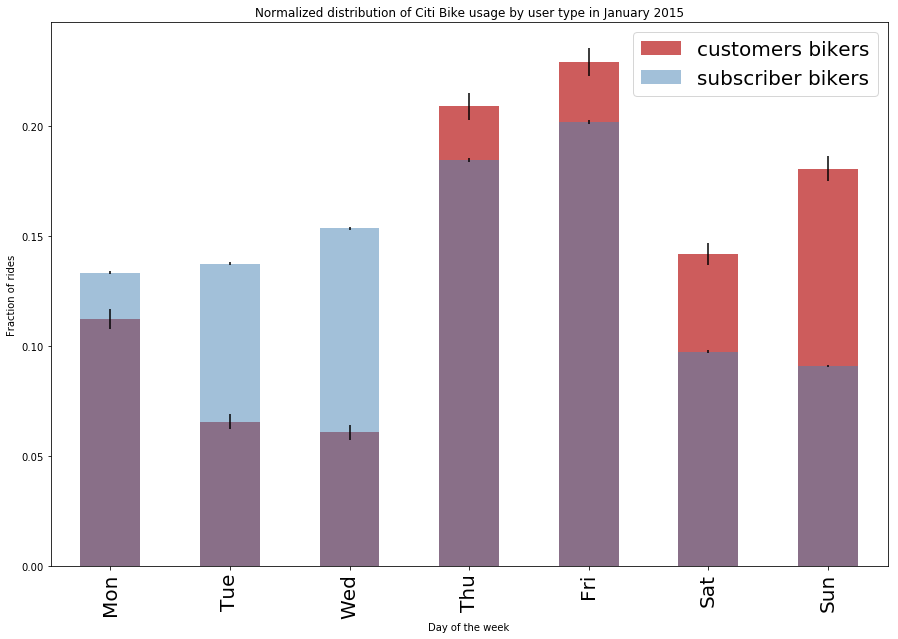

In [12]:
#difficult to compare absolute numbers, normalise the distribution of subscibers and customers 

fig = pl.figure(figsize(15,10))

norm_c = counts_c.sum()
error_c = np.sqrt(counts_c)
((counts_c) / norm_c).plot(kind="bar", color='IndianRed',  
                           yerr=[((error_c) / norm_c, (error_c) / norm_c)], 
                           label='customer bikers')

norm_s = counts_s.sum()
ax = ((counts_s) / norm_s).plot(kind="bar", alpha=0.5, 
                                yerr=[((error_s) / norm_s, (error_s) / norm_s)], 
                                color='SteelBlue', label='subscriber bikers')

ax.xaxis.set_ticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=20)
ax.set_ylabel ("Fraction of rides")
ax.set_xlabel ("Day of the week")
plt.title('Normalized distribution of Citi Bike usage by user type in January 2015')

pl.legend(['customers bikers','subscriber bikers'],fontsize=20)


# Figure 2: Normalized distribution of Citi Biky users by user type in January 2015